# Train and Data Analysis

- Use Jupyter Notebook for training
- Train on GCP to use Cuda

In [1]:
from Settings import Settings
Settings.learning_rate = 1e-4
Settings.dropout = 0.4 
Settings.epoch_num = 20 # 20 for RCNN Model
Settings.print_count = 4  # print 5 count for 1 epoch
Settings.batch_size = 100 # drop out are set in Model

In [2]:
from DataLoader import torch_dataset_loader
from TextCRNN import CRNNModel
from Train import main_train

import json
import matplotlib.pyplot as plt

In [3]:
# Dataloaders, use clean data (class balance data)
train_loader = torch_dataset_loader(Settings.train_path, Settings.batch_size, True, Settings.kwargs)
validation_loader = torch_dataset_loader(Settings.valid_path, Settings.batch_size, False, Settings.kwargs)
test_loader = torch_dataset_loader(Settings.test_path, Settings.batch_size, False, Settings.kwargs)

## Train Text RCNN Model

In [4]:
txtModel = CRNNModel()
log = main_train(txtModel, train_loader, validation_loader, "train(CRNN).json", "model(CRNN).h5")

Epoch  1 |  57/228 batches | 135.10ms/ batch | BCE: 0.2277 | Accuracy: 27.49% |
Epoch  1 | 114/228 batches | 134.06ms/ batch | BCE: 0.2102 | Accuracy: 33.79% |
Epoch  1 | 171/228 batches | 133.69ms/ batch | BCE: 0.1975 | Accuracy: 38.44% |
Epoch  1 | 228/228 batches | 133.23ms/ batch | BCE: 0.1878 | Accuracy: 41.84% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 30.40s | BCE: 0.1878 | Accuracy: 41.84% |
End of validation epoch   1 | time:  1.48s | BCE: 0.1499 | Accuracy: 56.64% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 |  57/228 batches | 135.79ms/ batch | BCE: 0.1480 | Accuracy: 56.00% |
Epoch  2 | 114/228 batches | 135.01ms/ batch | BCE: 0.1442 | Accuracy:

Epoch 11 |  57/228 batches | 135.96ms/ batch | BCE: 0.0648 | Accuracy: 83.25% |
Epoch 11 | 114/228 batches | 124.54ms/ batch | BCE: 0.0663 | Accuracy: 82.38% |
Epoch 11 | 171/228 batches | 111.14ms/ batch | BCE: 0.0660 | Accuracy: 82.58% |
Epoch 11 | 228/228 batches | 114.39ms/ batch | BCE: 0.0665 | Accuracy: 82.41% |
---------------------------------------------------------------------------------------------------
End of training epoch  11 | time: 26.10s | BCE: 0.0665 | Accuracy: 82.41% |
End of validation epoch  11 | time:  1.43s | BCE: 0.1013 | Accuracy: 72.44% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
---------------------------------------------------------------------------------------------------
Epoch 12 |  57/228 batches | 136.38ms/ batch | BCE: 0.0615 | Accuracy: 83.70% |
Epoch 12 | 114/228 batches | 135.71ms/ batch | BCE: 0.0615 | Accuracy: 84.04% |
Epoch 12 | 171/228 batches | 135.4

## Model Analysis

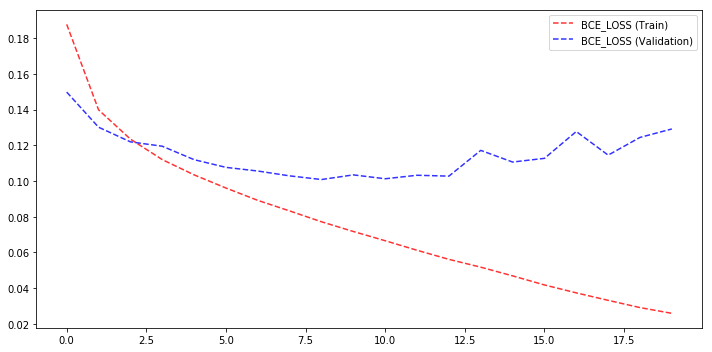

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(log['train_loss'], '--', color=(1,0,0,0.8), label='BCE_LOSS (Train)')
plt.plot(log['valid_loss'], '--', color=(0,0,1,0.8), label='BCE_LOSS (Validation)')
plt.tight_layout()
plt.legend(loc="best")
plt.show()

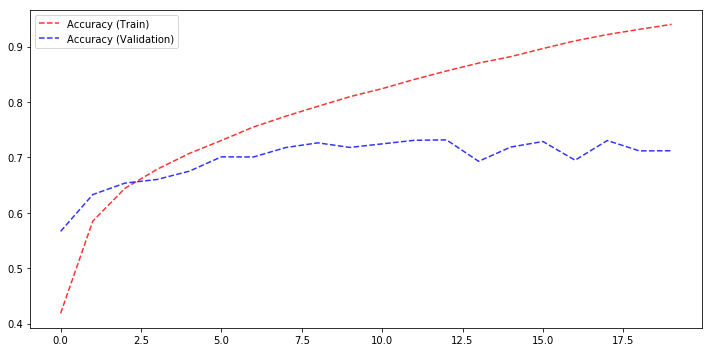

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(log['train_accu'], '--', color=(1,0,0,0.8), label='Accuracy (Train)')
plt.plot(log['valid_accu'], '--', color=(0,0,1,0.8), label='Accuracy (Validation)')
plt.tight_layout()
plt.legend(loc="best")
plt.show()

## Test Model on test set

In [7]:
from Train import validate_test
import torch

In [8]:
txtModel = CRNNModel()
txtModel.cuda().load_state_dict(torch.load(Settings.model_save_folder + 'model(CRNN).h5'))
validate_test(model=txtModel, epoch=0, use_loader=test_loader)

End of validation epoch   0 | time:  1.49s | BCE: 0.1040 | Accuracy: 73.49% |
---------------------------------------------------------------------------------------------------


(0.10398197533755467, 0.7348589341692789)

## Confusion Matrix

In [9]:
from Evaluate import Evaluator
model = CRNNModel()
evaluator = Evaluator(model, "model(CRNN).h5")

In [10]:
evaluator.record_matrix(test_loader, "textCRNNconfusion.json")

End of Matrix Record, Save file in ../LogSave/textCRNNconfusion.json
---------------------------------------------------------------------------------------------------


In [11]:
import numpy as np
import pandas as pd
import seaborn as sn

In [12]:
matrix = np.zeros((Settings.class_num, Settings.class_num))
with open(Settings.log_save_folder + 'textCRNNconfusion.json', 'r') as f:
    tuple_list = json.load(f)

In [13]:
for point in tuple_list:
    i, j = point  # i is predict, j is real, record 100 point for each label
    matrix[i][j] += 1

In [14]:
matrix /= sum(matrix)
matrix = pd.DataFrame(matrix, index = [evaluator.index_to_label.get(str(i+1)) for i in range(Settings.class_num)],
                  columns = [evaluator.index_to_label.get(str(i+1)) for i in range(Settings.class_num)],)

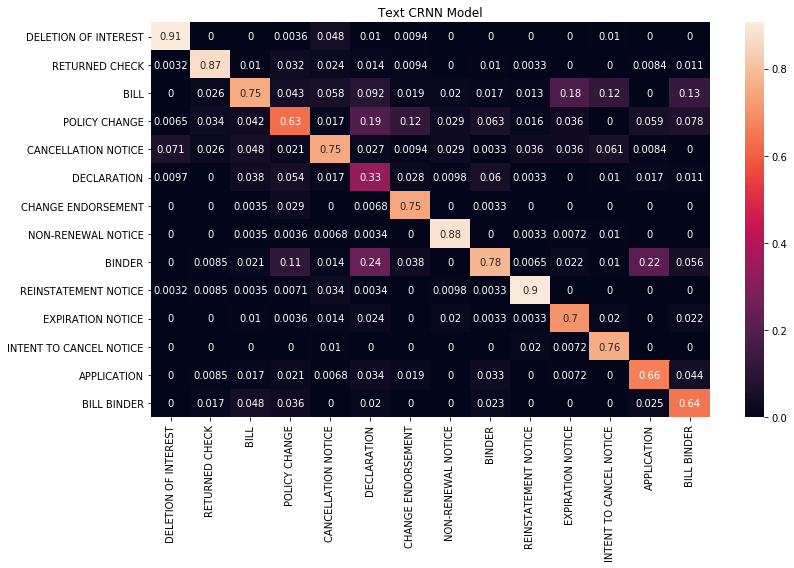

In [15]:
plt.figure(figsize=(12, 8))
plt.title('Text CRNN Model')
sn.heatmap(matrix, annot=True,)
plt.tight_layout()
plt.show()

## Conclusion
Current model has 74% accuracy on "chunk test"

# Test model on original set

In [17]:
import csv

csv_file = open(Settings.data_path, "r")
csv_reader = csv.reader(csv_file)

count = 0
right_count = 0
for line in csv_reader:
    label, doc = line
    pred_label, score = evaluator.label_predict(doc)
    count += 1
    if pred_label == label:
        right_count += 1
    if count > 1000:
        break

csv_file.close()
print(count, right_count)

1001 886


In [18]:
right_count/ count

0.8851148851148851

# Current Model Result

- 80% on full length document
- 75% on chunks